In [1]:
import os
import shap
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import xgboost as xgb
import catboost as cb
from sklearn import tree, svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, LeaveOneOut 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from progress.bar import IncrementalBar
from tqdm import tqdm
from sklearn.feature_selection import RFECV

In [2]:
cognitive_indicator = 'corsi'
indicator_folder = "D:/unn/down_syndrome_epigenetic/corsi"
alpha = 0.001

correlation_frame = pd.read_csv(r"D:\unn\down_syndrome_epigenetic\corsi\correlation_frame.txt", sep = '\t', index_col = 0)
methylation_frame = pd.read_csv(r"D:\unn\down_syndrome_epigenetic\corsi\methylation_frame.txt", sep = '\t', index_col = 0)
cognitive_frame = pd.read_csv(r"D:\unn\down_syndrome_epigenetic\corsi\cognitive_frame.txt", sep = '\t', index_col = 0)

In [3]:
def division_boundary_values (cognitive_indicator, cognitive_frame, class_values, lim1 = 0, lim2 = 0):
    if lim1 == 0 and lim2 == 0:
        splits = np.array_split(class_values, 3)
        lim1 = splits[0][-1]
        lim2 = splits[1][-1]
    
    classes = pd.DataFrame({'value': list(cognitive_frame[cognitive_indicator]), 'class': 0})
    for i in range(len(classes['value'])):
        if classes['value'].loc[i] <= lim1:
            classes.loc[i, 'class'] = 0
        elif classes['value'].loc[i] > lim1 and classes['value'].loc[i] <= lim2:
            classes.loc[i, 'class'] = 1
        else:
            classes.loc[i, 'class'] = 2
    classes_members = [list(classes['class']).count(0),
                       list(classes['class']).count(1),
                       list(classes['class']).count(2)]
    return classes, classes_members

def division_into_classes (cognitive_indicator, cognitive_frame, division_method = 0, lim1 = 0, lim2 = 0):
    if division_method != 3:
        class_values = sorted(list(cognitive_frame[cognitive_indicator]))
        classes_all, classes_all_members = division_boundary_values(cognitive_indicator, cognitive_frame, class_values)
        if division_method == 1:
            return classes_all
        class_values = sorted(list(set(cognitive_frame[cognitive_indicator])))
        classes_unique, classes_unique_members = division_boundary_values(cognitive_indicator, cognitive_frame, class_values)
        if division_method == 2:
            return classes_unique 
        return classes_all_members, classes_unique_members
    else:
        class_values = sorted(list(cognitive_frame[cognitive_indicator]))
        classes_user, classes_user_members = division_boundary_values(cognitive_indicator, cognitive_frame, class_values, lim1, lim2)
        return classes_user 

In [4]:
classes_all_members, classes_unique_members = division_into_classes (cognitive_indicator, cognitive_frame)
print('Division into classes \nall values:', *classes_all_members, '\nunique values:', *classes_unique_members)
division_method = int(input('\nChoose how to divide into classes:\n1. all values\n2. unique values\n3. manual division\n'))
if division_method == 3:
    print(sorted(list(cognitive_frame[cognitive_indicator])))
    lim1, lim2 = [int(i) for i in input('Enter boundary values: ').split(' ')]
    indicator_classes = division_into_classes(cognitive_indicator, cognitive_frame, division_method, lim1, lim2)
else:
    indicator_classes = division_into_classes(cognitive_indicator, cognitive_frame, division_method)

Division into classes 
all values: 14 8 6 
unique values: 9 13 6

Choose how to divide into classes:
1. all values
2. unique values
3. manual division
2


In [24]:
def SHAP_interpretation (model, model_name, X, correlation_frame, indicator_folder):
    indicator_folder_SHAP = '{0}/SHAP'.format(indicator_folder)
    if not os.path.isdir(indicator_folder_SHAP):
            os.mkdir(indicator_folder_SHAP)
    
    explainer = shap.KernelExplainer(model.predict, X)
    shap_values = explainer.shap_values(X)        
    
    x, y = 15, 12
    fig_inch = (x/2.54, y/2.54)
    fig = plt.figure()
    shap.summary_plot(shap_values, features = X, feature_names = correlation_frame.index, show = False)
    plt.gcf().set_size_inches(fig_inch)
    fig.patch.set_facecolor('white')
    plt.title(model_name)
    fig.savefig('{0}/beeswarm.png'.format(indicator_folder_SHAP), format = 'png', dpi = 300, bbox_inches = 'tight')

    for patient_id in len(shap_values):
        fig = plt.figure()
        shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[patient_id], 
                                               feature_names = correlation_frame.index, show = False)
        plt.gcf().set_size_inches(fig_inch)
        fig.patch.set_facecolor('white')
        fig.savefig('{0}/waterfall_legacy_{1}.png'.format(indicator_folder_SHAP, patient_id), 
                        format = 'png', dpi = 300, bbox_inches = 'tight')
        
def confusion_matrices (X, y, best_models, models_names, cognitive_indicator, indicator_folder):            
    for model_opt in best_models:
        cv = LeaveOneOut()
        pred_targets = np.array([])
        act_targets = np.array([])    
        for train_ix, test_ix in cv.split(X):
            Xm_train, Xm_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
            ym_train, ym_test = y.iloc[train_ix], y.iloc[test_ix]
            model_opt.fit(Xm_train, ym_train)    
            pred_labels = model_opt.predict(Xm_test)
            pred_targets = np.append(pred_targets, pred_labels)
            act_targets = np.append(act_targets, ym_test)

        acc_m = accuracy_score(act_targets, pred_targets)
        f1_m = f1_score(act_targets, pred_targets, average = 'macro')
        
        x, y = 15, 12
        fig_inch = (x/2.54, y/2.54)
        fig, ax = plt.subplots(figsize = fig_inch)
        cf_matrix = confusion_matrix(act_targets, pred_targets)
        ax = sns.heatmap(cf_matrix, annot = True, cmap = 'coolwarm')     
        ax.set_title('{0}\nAccuracy = {1:0.3f}, F1 = {2:0.3f}'.format(models_names[best_models.index(model_opt)], acc_m, f1_m), fontdict = {'size':'14'})
        ax.set_xlabel('Predicted', fontdict = {'size':'14'})
        ax.set_ylabel('Actual', fontdict = {'size':'14'})
        ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
        ax.xaxis.set_ticklabels(['Small','Medium', 'Large'])
        ax.yaxis.set_ticklabels(['Small','Medium', 'Large'])
        plt.tight_layout()
        plt.savefig('{0}/{1}_{2}_svg.svg'.format(indicator_folder, cognitive_indicator, models_names[best_models.index(model_opt)]), dpi = 300)
        plt.savefig('{0}/{1}_{2}_png.png'.format(indicator_folder, cognitive_indicator, models_names[best_models.index(model_opt)]), dpi = 300)
        plt.savefig('{0}/{1}_{2}_tif.tif'.format(indicator_folder, cognitive_indicator, models_names[best_models.index(model_opt)]), dpi = 300)
        plt.close()

def quality_metrics (y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = 'macro')
    return acc, f1

def Grid_Search_CV (model, params, X_train, X_test, 
                    y_train, y_test, acc_lst, f1_lst, 
                    best_params_lst, cv_err_lst):
    grid_cv = GridSearchCV(estimator = model, param_grid = params, cv = 5, n_jobs = -1)
    grid_cv.fit(X_train, y_train)
    y_pred = grid_cv.predict(X_test)
    best_params, cv_err = grid_cv.best_params_, grid_cv.best_score_
    
    acc, f1 = quality_metrics (y_test, y_pred)
    acc_lst.append(acc)
    f1_lst.append(f1)
    best_params_lst.append(best_params)
    cv_err_lst.append(cv_err)
    
    return grid_cv, best_params_lst, cv_err_lst, acc_lst, f1_lst

def ML_classification (correlation_frame, methylation_frame, indicator_classes, cognitive_indicator, indicator_folder):
    indicator_folder = '{0}/ML_classification'.format(indicator_folder)
    if not os.path.isdir(indicator_folder):
            os.mkdir(indicator_folder)
            
    X = methylation_frame[correlation_frame.index].values
    y = indicator_classes['class']
    X = (X - X.mean(axis = 0)) / X.std(axis = 0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 111, stratify = y)
    best_params_lst, cv_err_lst = [], []
    acc_lst, f1_lst = [], []
    
    dtree_model = tree.DecisionTreeClassifier(random_state = 111)
    params = {'max_depth': range (1, 4, 1)}
    dtree_best_model, best_params_lst, cv_err_lst, acc_lst, f1_lst = Grid_Search_CV(dtree_model, params, X_train, X_test, 
                                                                                    y_train, y_test, acc_lst, f1_lst, 
                                                                                    best_params_lst, cv_err_lst)
    rf_model = RandomForestClassifier(random_state = 111)
    params = {'n_estimators': range(10, 110, 10)}
    rf_best_model, best_params_lst, cv_err_lst, acc_lst, f1_lst = Grid_Search_CV(rf_model, params, X_train, X_test, 
                                                                                 y_train, y_test, acc_lst, f1_lst, 
                                                                                 best_params_lst, cv_err_lst)
    xg_model = xgb.XGBClassifier(objective ='multi:softprob', random_state = 111)
    params = {'max_depth': range (1, 4, 1), 'n_estimators': range(10, 110, 10), 
              'learning_rate': [0.1, 0.01, 0.05]}
    xgb.set_config(verbosity = 0)
    xg_best_model, best_params_lst, cv_err_lst, acc_lst, f1_lst = Grid_Search_CV(xg_model, params, X_train, X_test, 
                                                                                 y_train, y_test, acc_lst, f1_lst, 
                                                                                 best_params_lst, cv_err_lst)
    cb_model = cb.CatBoostClassifier(loss_function = 'MultiClass', random_state = 111)
    params = {'iterations': [100, 150, 200], 'learning_rate': [0.03, 0.1], 
              'depth': [2, 3, 4], 'l2_leaf_reg': [0.2, 0.5, 1, 3]}
    cb_best_model, best_params_lst, cv_err_lst, acc_lst, f1_lst = Grid_Search_CV(cb_model, params, X_train, X_test, 
                                                                                 y_train, y_test, acc_lst, f1_lst, 
                                                                                 best_params_lst, cv_err_lst)
    
    lda_model = LDA()
    params = [{'solver': ['svd', 'lsqr', 'eigen']}]
    lda_best_model, best_params_lst, cv_err_lst, acc_lst, f1_lst = Grid_Search_CV(lda_model, params, X_train, X_test, 
                                                                                  y_train, y_test, acc_lst, f1_lst, 
                                                                                  best_params_lst, cv_err_lst)
    qda_model = QDA()
    params = [{'reg_param': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]}]
    qda_best_model, best_params_lst, cv_err_lst, acc_lst, f1_lst = Grid_Search_CV(qda_model, params, X_train, X_test, 
                                                                                  y_train, y_test, acc_lst, f1_lst, 
                                                                                  best_params_lst, cv_err_lst)
    logist = LogisticRegression(solver = 'liblinear')
    params = [{'C': np.logspace(-3, 3, 7), 'penalty': ['l1', 'l2']}]
    logist_best_model, best_params_lst, cv_err_lst, acc_lst, f1_lst = Grid_Search_CV(logist, params, X_train, X_test, 
                                                                                     y_train, y_test, acc_lst, f1_lst, 
                                                                                     best_params_lst, cv_err_lst)
    svc_linear = svm.SVC(kernel = 'linear')
    params = [{'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]}]
    best_svc_linear, best_params_lst, cv_err_lst, acc_lst, f1_lst = Grid_Search_CV(svc_linear, params, X_train, X_test, 
                                                                                   y_train, y_test, acc_lst, f1_lst, 
                                                                                   best_params_lst, cv_err_lst)
    svc_rbf = svm.SVC(kernel = 'rbf')
    params = [{'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 2.0], 'coef0': [0.0001, 0.001, 0.01, 0.1, 0.2, 1.0],
              'C': [40, 50, 60, 70, 80, 90]}]
    best_svc_rbf, best_params_lst, cv_err_lst, acc_lst, f1_lst = Grid_Search_CV(svc_rbf, params, X_train, X_test, 
                                                                                y_train, y_test, acc_lst, f1_lst, 
                                                                                best_params_lst, cv_err_lst)
    svc_poly = svm.SVC(kernel = 'poly')
    params = [{'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 2.0], 'coef0': [0.0001, 0.001, 0.01, 0.1, 0.2, 1.0], 
              'C': [0.001, 0.01, 0.1, 1.0, 2.0, 5.0]}]
    best_svc_poly, best_params_lst, cv_err_lst, acc_lst, f1_lst = Grid_Search_CV(svc_poly, params, X_train, X_test, 
                                                                                 y_train, y_test, acc_lst, f1_lst, 
                                                                                 best_params_lst, cv_err_lst)
    best_models = [dtree_best_model, rf_best_model, xg_best_model, cb_best_model, lda_best_model, 
                   qda_best_model, logist_best_model, best_svc_linear, best_svc_rbf, best_svc_poly]
    models_names = ['Desicion Tree', 'Random Forest', 'XGBoost', 'Catboost', 'LDA', 'QDA', 'Logistic regression', 
                    'SVC (linear kernel)', 'SVC (rbf kernel)', 'SVC (poly kernel)']
    
    CL_models = open('{0}/CL_models.txt'.format(indicator_folder), 'w')
    for i in range(len(models_names)):
        text = str(models_names[i]) + '\nbest params: ' + str(best_params_lst[i]) + '\nCV error = ' + str(cv_err_lst[i]) + '\nAccuracy = ' + str(acc_lst[i]) + '\nf1 = ' + str(f1_lst[i]) + '\n\n'
        CL_models.write(text)
    CL_models.close()
    
    confusion_matrices(X, y, best_models, models_names, cognitive_indicator, indicator_folder)
    
    best_model_ind = acc_lst.index(max(acc_lst))
    SHAP_interpretation(best_models[best_model_ind], models_names[best_model_ind], X, correlation_frame, indicator_folder)
        
    

In [62]:
methylation_frame[correlation_frame.index].values

array([[0.57886887, 0.29787216, 0.01261925, ..., 0.01328135, 0.84875625,
        0.05028677],
       [0.67036015, 0.4262362 , 0.01785992, ..., 0.01384891, 0.8603866 ,
        0.06821622],
       [0.663158  , 0.40857026, 0.01922581, ..., 0.01674174, 0.7851931 ,
        0.10607845],
       ...,
       [0.6345485 , 0.38285524, 0.01860993, ..., 0.0150003 , 0.80481136,
        0.0924546 ],
       [0.69237185, 0.42694873, 0.02001639, ..., 0.01390312, 0.7734368 ,
        0.06477937],
       [0.7124195 , 0.4515766 , 0.02068484, ..., 0.0158811 , 0.8110887 ,
        0.08276413]])

  0%|          | 0/28 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

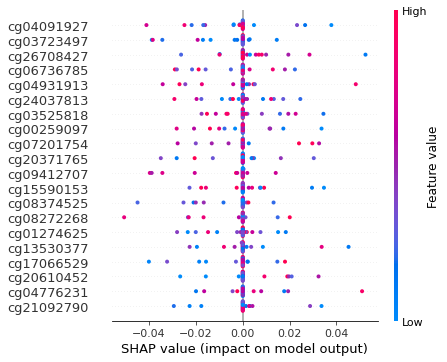

In [6]:
X = methylation_frame[correlation_frame.index].values
y = indicator_classes['class']

X = (X - X.mean(axis = 0)) / X.std(axis = 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 111, stratify = y)

model = svm.SVC(kernel = 'rbf', probability=True)
params = {'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 2.0],
          'coef0': [0.0001, 0.001, 0.01, 0.1, 0.2, 1.0],
          'C': [40, 50, 60, 70, 80, 90]} 

grid_cv = GridSearchCV(estimator = model, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs = -1)
grid_cv.fit(X_train, y_train)
    
best_params = grid_cv.best_params_
cv_err = grid_cv.best_score_
y_pred = grid_cv.predict(X_test)
  
explainer = shap.KernelExplainer(grid_cv.predict, X_train)
shap_values = explainer.shap_values(X)    
indicator_folder_SHAP = '{0}/SHAP'.format(indicator_folder)
if not os.path.isdir(indicator_folder_SHAP):
        os.mkdir(indicator_folder_SHAP)
    
x, y = 15, 12
fig_inch = (x/2.54, y/2.54)
fig = plt.figure()
shap.summary_plot(shap_values, features = X, feature_names = correlation_frame.index, show = False)
plt.gcf().set_size_inches(fig_inch)
fig.patch.set_facecolor('white')
fig.savefig('{0}/beeswarm.png'.format(indicator_folder_SHAP), format = 'png', dpi = 300, bbox_inches = 'tight')

for patient_number in range(len(shap_values)):
    fig = plt.figure()
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[patient_number], 
                                           feature_names = correlation_frame.index, show = False)
    plt.gcf().set_size_inches(fig_inch)
    fig.patch.set_facecolor('white')
    fig.savefig('{0}/waterfall_legacy_{1}.png'.format(indicator_folder_SHAP, patient_number), 
                    format = 'png', dpi = 300, bbox_inches = 'tight')
    plt.close()

In [8]:
#изменено

def quality_metrics (y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = 'macro')
    return acc, f1

def Grid_Search_CV (model, params, X, y, acc_lst, f1_lst, 
                    best_params_lst, cv_err_lst):
    X = (X - X.mean(axis = 0)) / X.std(axis = 0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 111, stratify = y)
    rfecv = RFECV(estimator = model, scoring = "accuracy", cv = 5)
    rfecv.fit(X, y)
    rfecv.transform(X)
    
    grid_cv = GridSearchCV(estimator = model, param_grid = params, cv = 5, n_jobs = -1)
    grid_cv.fit(X_train, y_train)
    best_model, best_params, cv_err = grid_cv.best_estimator_, grid_cv.best_params_, grid_cv.best_score_
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    
    acc, f1 = quality_metrics (y_test, y_pred)
    acc_lst.append(acc)
    f1_lst.append(f1)
    best_params_lst.append(best_params)
    cv_err_lst.append(cv_err)
    
    return best_model, best_params_lst, cv_err_lst, acc_lst, f1_lst

def ML_classification (correlation_frame, methylation_frame, indicator_classes, cognitive_indicator, indicator_folder):
    X = methylation_frame[list(correlation_frame.index)]
    y = indicator_classes['class']    
    best_params_lst, cv_err_lst = [], []
    acc_lst, f1_lst = [], []
    
    lda_model = LDA()
    params = [{'solver': ['svd', 'lsqr', 'eigen']}]
    lda_best_model, best_params_lst, cv_err_lst, acc_lst, f1_lst = Grid_Search_CV(lda_model, params, X, y, acc_lst, f1_lst, 
                                                                                  best_params_lst, cv_err_lst)
    logist = LogisticRegression(solver = 'liblinear')
    params = [{'C': np.logspace(-3, 3, 7), 'penalty': ['l1', 'l2']}]
    logist_best_model, best_params_lst, cv_err_lst, acc_lst, f1_lst = Grid_Search_CV(logist, params, X, y, acc_lst, f1_lst, 
                                                                                     best_params_lst, cv_err_lst)
    svc_linear = svm.SVC(kernel = 'linear')
    params = [{'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]}]
    best_svc_linear, best_params_lst, cv_err_lst, acc_lst, f1_lst = Grid_Search_CV(svc_linear, params, X, y, acc_lst, f1_lst, 
                                                                                   best_params_lst, cv_err_lst)
    svc_rbf = svm.SVC(kernel = 'rbf')
    params = [{'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 2.0], 'coef0': [0.0001, 0.001, 0.01, 0.1, 0.2, 1.0],
              'C': [40, 50, 60, 70, 80, 90]}]
    best_svc_rbf, best_params_lst, cv_err_lst, acc_lst, f1_lst = Grid_Search_CV(svc_rbf, params, X, y, acc_lst, f1_lst, 
                                                                                best_params_lst, cv_err_lst)
    svc_poly = svm.SVC(kernel = 'poly')
    params = [{'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 2.0], 'coef0': [0.0001, 0.001, 0.01, 0.1, 0.2, 1.0], 
              'C': [0.001, 0.01, 0.1, 1.0, 2.0, 5.0]}]
    best_svc_poly, best_params_lst, cv_err_lst, acc_lst, f1_lst = Grid_Search_CV(svc_poly, params, X, y, acc_lst, f1_lst, 
                                                                                 best_params_lst, cv_err_lst)
    best_models = [dtree_best_model, rf_best_model, xg_best_model, cb_best_model, lda_best_model, 
                   qda_best_model, logist_best_model, best_svc_linear, best_svc_rbf, best_svc_poly]
    models_names = ['Desicion Tree', 'Random Forest', 'XGBoost', 'Catboost', 'LDA', 'QDA', 'Logistic regression', 
                    'SVC (linear kernel)', 'SVC (rbf kernel)', 'SVC (poly kernel)']
    
    CL_models2 = open('{0}/CL_models_2.txt'.format(indicator_folder), 'w')
    for i in range(0, len(models_names)):
        text = str(models_names[i]) + '\nbest params: ' + str(best_params_lst[i]) + '\nCV error = ' + str(cv_err_lst[i]) + '\nAccuracy = ' + str(acc_lst[i]) + '\nf1 = ' + str(f1_lst[i]) + '\n\n'
        CL_models2.write(text)
    CL_models2.close()
    return best_params_lst, cv_err_lst, acc_lst, f1_lst

In [ ]:
 use_label_encoder = False,

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X = methylation_frame[list(correlation_frame.index)]
y = indicator_classes['class']

X = (X - X.mean(axis = 0)) / X.std(axis = 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 111)

def Grid_Search_CV(model, params, X_train, X_test, y_train, y_test):
    grid_cv = GridSearchCV(estimator = model, param_grid = params, cv = 5, n_jobs = -1)
    grid_cv.fit(X_train, y_train)
    
    best_model = grid_cv.best_estimator_
    best_model.fit(X_train, y_train)
    best_params = grid_cv.best_params_
    cv_err = grid_cv.best_score_
    y_pred = best_model.predict(X_test)
    return best_model, best_params, cv_err, y_pred

lda_model = LDA()
params = [{'solver': ['svd', 'lsqr', 'eigen']}]
lda_best_model, best_prams, cv_err, y_pred = Grid_Search_CV(lda_model, params, X_train, X_test, y_train, y_test)

print('LDA:', '\nbest params:', best_prams, '\nCV error =', cv_err, 
     '\nAccuracy =', accuracy_score(y_test, y_pred), '\nF =', f1_score(y_test, y_pred, average = 'macro'))

LDA: 
best params: {'solver': 'svd'} 
CV error = 0.5900000000000001 
Accuracy = 0.5 
F = 0.3571428571428572



5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py", line 599, in fit
    self._solve_eigen(
  File "D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py", line 440, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "C:\Users\kozlo\AppData\Roaming\Python\Python39\site-packages\scipy\linalg\_decomp.py", line 594, in eigh
    raise LinAlgError('The leading minor of order {} of B is not '

In [18]:
X = methylation_frame[list(correlation_frame.index)]
y = indicator_classes['class']

X = (X - X.mean(axis = 0)) / X.std(axis = 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 111)

def Grid_Search_CV(model, params, X_train, X_test, y_train, y_test):
    grid_cv = GridSearchCV(estimator = model, param_grid = params, cv = 5, n_jobs = -1)
    grid_cv.fit(X_train, y_train)
    
    best_params = grid_cv.best_params_
    cv_err = grid_cv.best_score_
    y_pred = grid_cv.predict(X_test)
    return grid_cv, best_params, cv_err, y_pred

lda_model = LDA()
params = [{'solver': ['svd', 'lsqr', 'eigen']}]
lda_best_model, best_prams, cv_err, y_pred = Grid_Search_CV(lda_model, params, X_train, X_test, y_train, y_test)

print('LDA:', '\nbest params:', best_prams, '\nCV error =', cv_err, 
     '\nAccuracy =', accuracy_score(y_test, y_pred), '\nF =', f1_score(y_test, y_pred, average = 'macro'))

LDA: 
best params: {'solver': 'svd'} 
CV error = 0.5900000000000001 
Accuracy = 0.5 
F = 0.3571428571428572



5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py", line 599, in fit
    self._solve_eigen(
  File "D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py", line 440, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "C:\Users\kozlo\AppData\Roaming\Python\Python39\site-packages\scipy\linalg\_decomp.py", line 594, in eigh
    raise LinAlgError('The leading minor of order {} of B is not '

In [54]:
X = methylation_frame[correlation_frame.index]
y = indicator_classes['class']

X = (X - X.mean(axis = 0)) / X.std(axis = 0)



In [55]:
X

,cg09931783,cg11111139,cg26330326,cg17394978,cg25603108,cg19636302,cg24257309,cg19127840,cg15567428,cg01444716,...,cg17155018,cg23054181,cg10536916,cg23836542,cg14111928,cg13372456,cg27306119,cg02291204,cg12026891,cg06381964
1001,-1.239162,-2.136250,-1.883715,1.498007,-1.164528,-1.151469,-1.695273,-1.543058,-1.763648,-1.132743,...,-1.230520,-1.259977,-1.029347,-1.247306,-1.171447,-1.417413,-1.557061,-0.952594,1.110417,-1.142206
1003,0.945454,0.595562,0.579858,-0.537119,-0.318900,-0.143430,0.843432,-0.092269,0.366732,-0.346595,...,0.599839,-0.473808,-0.682123,-0.991565,-0.674472,-0.599953,-0.822237,-0.584715,1.369736,-0.562444
1007,0.773482,0.219600,1.221944,-0.027221,0.422474,0.491565,0.700021,0.326213,0.665343,0.916805,...,-0.601063,-0.050220,-0.229692,0.459748,0.174275,-0.312193,0.043877,1.290339,-0.306840,0.661861
1009,-0.865499,-0.193973,0.455862,0.180966,0.025811,-0.008549,0.167094,-0.184905,1.405013,-0.329850,...,-0.878700,-0.294023,-0.113379,-0.445306,0.126803,-0.112240,-0.129716,-0.632673,-0.612068,-0.243183
1010,-0.989098,0.006236,-0.527548,0.640925,-0.815460,0.433345,0.006560,0.827547,0.740666,0.406740,...,-0.617211,0.066798,0.888249,1.343821,0.281493,2.117912,-0.688314,0.444174,-1.738490,1.983365
1011,-0.012435,1.052502,0.718767,-0.978269,-0.085130,0.387839,0.971762,0.659192,0.267899,0.717034,...,-0.653539,0.878764,1.171320,1.803207,0.719587,0.848998,1.647331,3.140674,-1.662065,1.652625
1013,1.823836,1.531925,0.176442,-0.608790,1.956859,0.874478,0.980085,0.977672,0.855768,1.642908,...,2.165394,1.440843,0.744293,0.855341,1.238755,0.515821,-0.270630,0.036039,0.058587,-0.014521
1020,-1.210127,-0.375903,-1.256553,0.227720,-0.868722,-0.321731,0.441060,-0.821195,-1.033376,-0.896041,...,1.021637,-0.438659,-0.933450,-1.588068,-1.917403,-1.074200,-0.766740,-1.284220,1.075835,-1.122774
1023,1.103252,1.065658,0.731131,-1.376989,2.035095,1.300874,0.934464,0.982985,2.261393,0.775767,...,0.382433,1.498639,3.665612,0.612079,0.960641,-0.380824,-0.502049,-0.933118,-0.188880,0.507153
1028,-1.679513,-0.794613,-0.908550,1.150789,-0.749085,-0.476786,-1.019526,-0.836865,-1.230877,-0.550044,...,-0.826679,-0.387782,-0.316715,-0.256926,-1.293769,-0.344310,-0.933406,-1.039960,0.468657,-0.723130


In [56]:
y

0     0
1     1
2     1
3     1
4     0
5     1
6     2
7     1
8     1
9     0
10    1
11    0
12    1
13    1
14    2
15    2
16    0
17    2
18    0
19    2
20    0
21    1
22    0
23    0
24    1
25    1
26    1
27    2
Name: class, dtype: int64

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 111)

In [59]:
svc_rbf = svm.SVC(kernel = 'rbf', probability=True)
params = {'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 2.0],
          'coef0': [0.0001, 0.001, 0.01, 0.1, 0.2, 1.0],
          'C': [40, 50, 60, 70, 80, 90]} 

grid_cv = GridSearchCV(estimator = model, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs = -1)
grid_cv.fit(X_train, y_train)
    
best_params = grid_cv.best_params_
cv_err = grid_cv.best_score_
rbf_pred = grid_cv.predict(X_test)

acc_test = accuracy_score(y_test, rbf_pred)
f1_test = f1_score(y_test, rbf_pred, average = 'macro')
print('\nAccuracy =', acc_test, ', f1 =', f1_test)


Accuracy = 0.8333333333333334 , f1 = 0.8666666666666667


In [58]:
svc_rbf = svm.SVC(kernel = 'rbf', probability=True)

params = {'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 2.0],
          'coef0': [0.0001, 0.001, 0.01, 0.1, 0.2, 1.0],
          'C': [40, 50, 60, 70, 80, 90]} 

grid_cv = GridSearchCV(svc_rbf, param_grid = params, 
                       cv = 5, scoring = 'accuracy', n_jobs = -1)
grid_cv.fit(X_train, y_train)
print('RBF kernel:')
print('\nCV error =', grid_cv.best_score_)

svc_rbf = svm.SVC(kernel = 'rbf', gamma = grid_cv.best_estimator_.gamma, coef0 = grid_cv.best_estimator_.coef0, 
                  C = grid_cv.best_estimator_.C)
svc_rbf.fit(X_train, y_train)
rbf_pred = svc_rbf.predict(X_test)

print('\nSVC, R train =', np.mean(y_train != svc_rbf.predict(X_train)))
print('SVC, R test =', np.mean(y_test != rbf_pred))

acc_test = accuracy_score(y_test, rbf_pred)
f1_test = f1_score(y_test, rbf_pred, average = 'macro')
print('\nAccuracy =', acc_test, ', f1 =', f1_test)

RBF kernel:

CV error = 0.6

SVC, R train = 0.0
SVC, R test = 0.16666666666666666

Accuracy = 0.8333333333333334 , f1 = 0.8666666666666667


In [61]:
explainer = shap.KernelExplainer(grid_cv.predict, X)
shap_values = explainer.shap_values(X)    
    
x, y = 15, 12
fig_inch = (x/2.54, y/2.54)
fig = plt.figure()
shap.summary_plot(shap_values, features = X, feature_names = correlation_frame.index, show = False)
plt.gcf().set_size_inches(fig_inch)
fig.patch.set_facecolor('white')
fig.savefig('{0}/beeswarm.png'.format(indicator_folder_SHAP), format = 'png', dpi = 300, bbox_inches = 'tight')

for patient_number in shap_values:
    fig = plt.figure()
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[patient_number], 
                                           feature_names = correlation_frame.index, show = False)
    plt.gcf().set_size_inches(fig_inch)
    fig.patch.set_facecolor('white')
    fig.savefig('{0}/waterfall_legacy_{1}.png'.format(indicator_folder_SHAP, patient_number), 
                    format = 'png', dpi = 300, bbox_inches = 'tight')
    patient_number += 1
    plt.close()

X does not have valid feature names, but SVC was fitted with feature names


  0%|          | 0/28 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprec

KeyboardInterrupt: 

In [66]:
shap_values

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00304014,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.00199769,
         0.        ,  0.0005502 ],
       ...,
       [-0.00273388,  0.        ,  0.        , ...,  0.        ,
        -0.00302608,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [8]:
indicator_classes

,value,class
0,0.0,0
1,3.0,1
2,3.0,1
3,3.0,1
4,1.0,0
5,3.0,1
6,4.0,2
7,2.0,1
8,3.0,1
9,0.0,0


,class
0,0
1,1
2,1
3,1
4,0
5,1
6,2
7,1
8,1
9,0
